# Import des modules et des fichiers CSV

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

# Nettoyage & analyse de 'customers'

## Customers : Diagnostic

In [3]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
customers.tail()
# numéro client avec seulement deux chiffres

,client_id,sex,birth
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968
8622,c_84,f,1982


In [5]:
customers.shape

(8623, 3)

In [6]:
customers.info()
# pas de NaN
# sex peut-être changé en 'category' afin de gagner en place

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [7]:
customers.describe()
# pas de valeur aberrante

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [8]:
customers.columns
#pas de problème d'espace dans les noms de colonnes

Index(['client_id', 'sex', 'birth'], dtype='object')

In [9]:
customers.client_id.value_counts()
#Pas de doublon dans les numéros de client --> clé primaire OK

c_3915    1
c_570     1
c_1413    1
c_2274    1
c_4924    1
         ..
c_4594    1
c_3723    1
c_7500    1
c_3357    1
c_5660    1
Name: client_id, Length: 8623, dtype: int64

In [10]:
customers.sex.value_counts()
#pas de valeur autre que f/m

f    4491
m    4132
Name: sex, dtype: int64

In [11]:
list(customers.sex.value_counts().values)

[4491, 4132]

In [12]:
list(customers.sex.value_counts().values)

[4491, 4132]

In [13]:
help(plt.pie)

Help on function pie in module matplotlib.pyplot:

pie(x, explode=None, labels=None, colors=None, autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=None, radius=None, counterclock=True, wedgeprops=None, textprops=None, center=(0, 0), frame=False, rotatelabels=False, *, data=None)
    Plot a pie chart.
    
    Make a pie chart of array *x*.  The fractional area of each wedge is
    given by ``x/sum(x)``.  If ``sum(x) < 1``, then the values of *x* give
    the fractional area directly and the array will not be normalized. The
    resulting pie will have an empty wedge of size ``1 - sum(x)``.
    
    The wedges are plotted counterclockwise, by default starting from the
    x-axis.
    
    Parameters
    ----------
    x : array-like
        The wedge sizes.
    
    explode : array-like, optional, default: None
        If not *None*, is a ``len(x)`` array which specifies the fraction
        of the radius with which to offset each wedge.
    
    labels : list,

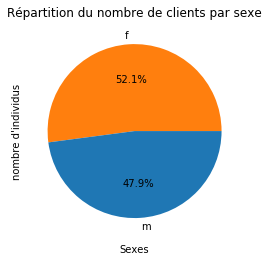

In [14]:
# visualisation des clients par sexe

plt.pie(customers.sex.value_counts(), labels=(customers.sex.value_counts().index), autopct='%1.1f%%', colors=('tab:orange', 'tab:blue'))
plt.title('Répartition du nombre de clients par sexe')
plt.xlabel('Sexes')
plt.ylabel('''nombre d'individus''')
plt.savefig('repartion_par_sexes')
plt.show()

## Nombre de clients par année de naissance

In [15]:
# On compte le nombre de clients en les regroupant par leur année de naissance
birth_count = customers.groupby('birth').count()

In [16]:
birth_count.reset_index(inplace= True)

In [17]:
# Sélection des colonnes
birth_count = birth_count[['birth', 'client_id']]
# changement de nom des colonnes
birth_count.columns = ['birth', 'nb_client']
birth_count

,birth,nb_client
0,1929,3
1,1930,4
2,1931,4
3,1932,6
4,1933,8
...,...,...
71,2000,136
72,2001,129
73,2002,146
74,2003,146


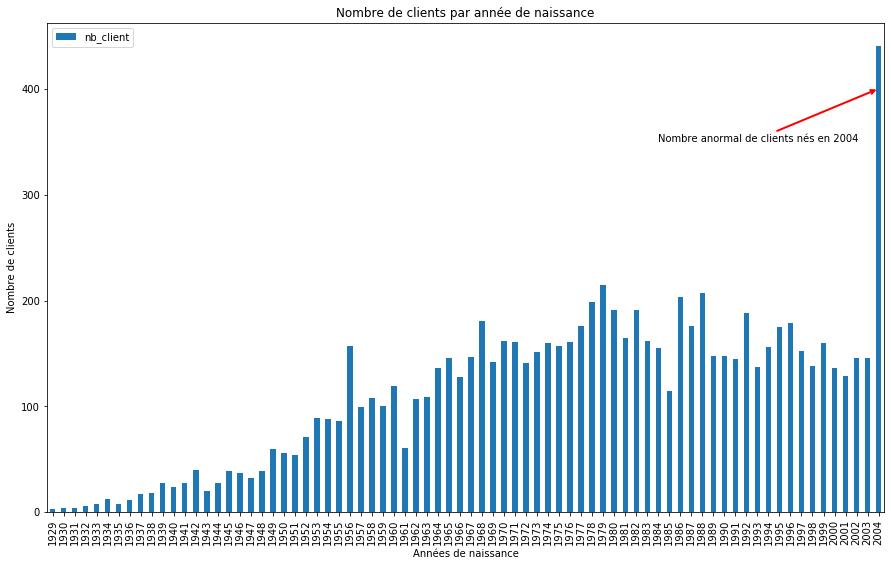

In [18]:
# visualisation du nombre de clients par année de naissance en utilisant un diagramme à bars

birth_count.plot(x='birth', y='nb_client', kind='bar', figsize=(15,9))
plt.title('Nombre de clients par année de naissance')
plt.xlabel('Années de naissance')
plt.ylabel('Nombre de clients')
plt.annotate('Nombre anormal de clients nés en 2004', xy=(75,400), xytext=(55,350),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.savefig('clients_par_naissance')
plt.show()

# l'année de naissance 2004 correspondant à l'âge de 18ans, est fortement représenté, 
# ce qui laisse penser que beaucoup d'acheteur ont moins de 18 ans et utilise l'année de naissance minimum

### Transformation de la colonne "sex" de 'object' (chaîne de caractère) à 'category'

In [19]:
# Définition du type de la variable 'sex' vers une variable du type 'catégory'
customers.sex = customers.sex.astype('category')

In [20]:
customers.info()
# On passe de 202 KB à 143 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   client_id  8623 non-null   object  
 1   sex        8623 non-null   category
 2   birth      8623 non-null   int64   
dtypes: category(1), int64(1), object(1)
memory usage: 143.4+ KB


### Identification des numéros de client avec un format différent de 'c_xxxx'

In [21]:
pattern = re.compile('c_\d*') # création d'un pattern standard
mask= customers.client_id.str.contains(pattern)
print(customers.client_id[~mask]) # utilisation du tilde pour identifier les entrées qui ne correspondent pas au pattern
ct_list = list(customers.client_id[~mask]) # Sauvegarde des client_id du format 'ct_x' dans une liste
display(customers[customers.client_id.isin(ct_list)])

2735    ct_0
8494    ct_1
Name: client_id, dtype: object


,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


# Nettoyage de 'products'

## Products : diagnostic

In [22]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [23]:
products.tail()

,id_prod,price,categ
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [24]:
products.shape

(3287, 3)

In [25]:
products.columns
#Pas d'espace en trop

Index(['id_prod', 'price', 'categ'], dtype='object')

In [26]:
products.info()
# Pas de NaN 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


### Description générale

In [27]:
products.describe()
# prix négatif --> analyser le -1 dans transac
# indicateurs de dispersion élevés, préféré une description par categ

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


### Description par catégorie

In [28]:
# Groupement des données par catégorie avec pour fonction d'aggrégation .describe()
products_describe = products.groupby('categ')['price'].describe()
products_describe

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,2309.0,11.727280,7.568756,-1.00,5.580,10.32,16.65,40.99
1,739.0,25.531421,15.425162,2.00,13.390,22.99,33.99,80.99
2,239.0,108.354686,49.561431,30.99,71.065,101.99,136.53,300.00


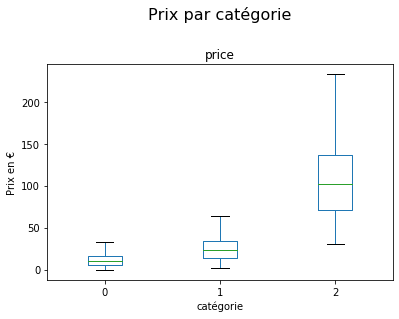

In [29]:
# Boîtes à moustache de la distribution des prix en fonction de la catégorie
# Version sans les valeurs aberrantes
products.boxplot(column='price', by='categ', showfliers=False, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)
plt.xlabel('catégorie')
plt.ylabel('Prix en €')
plt.savefig('prix_categ')
plt.show()

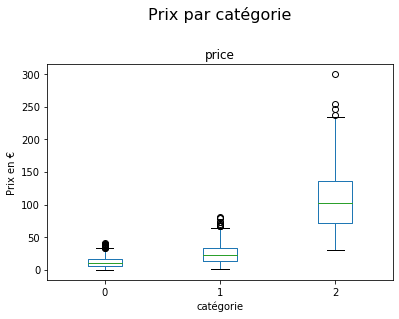

In [30]:
# Avec les valeurs aberrantes
products.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)
plt.xlabel('catégorie')
plt.ylabel('Prix en €')
plt.savefig('prix_categ_outliers')

### Clé primaire

In [31]:
# est-ce que id_prod est une clé primaire candidate ?
products.id_prod.value_counts()
# Pas de doublons --> clé primaire potentiel

0_1768    1
2_35      1
0_1599    1
1_145     1
0_540     1
         ..
0_1500    1
0_1443    1
0_325     1
0_1350    1
2_137     1
Name: id_prod, Length: 3287, dtype: int64

In [32]:
products.categ.value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

### Identification du produit ayant une valeur négatif

In [33]:
# on sauvegarde le numéro produit de l'article avec un prix négatif

id_product_neg = products[products.price == -1]['id_prod'].values
id_product_neg = id_product_neg[0]
products[products.id_prod == id_product_neg]

,id_prod,price,categ
731,T_0,-1.0,0


## Products : modifications

### Modification du type de 'categ' d'objet à catégorie

In [34]:
products.categ = products.categ.astype('category')

In [35]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [36]:
products.info()
# de 77 KB à 54.8 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id_prod  3287 non-null   object  
 1   price    3287 non-null   float64 
 2   categ    3287 non-null   category
dtypes: category(1), float64(1), object(1)
memory usage: 54.8+ KB


## Products : Représentation graphique de la distribution des prix en fonction de la catégorie

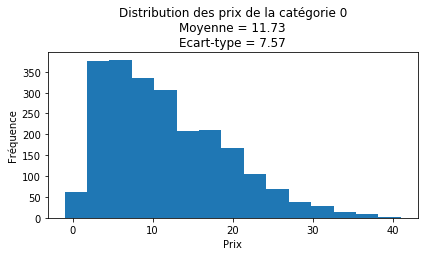

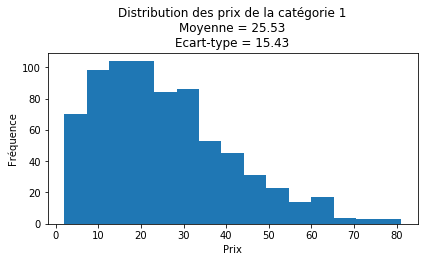

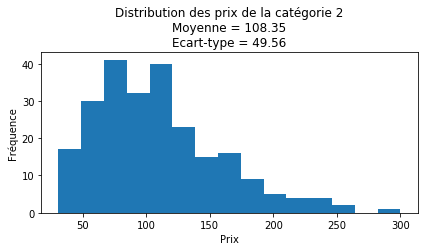

In [37]:
### création d'une boucle qui va retourner un histogramme, la moyenne, et l'écart-type des prix en fonction de la catégorie


i=0

while i < 3 :
    mu = products_describe.loc[i,'mean']
    sigma = products_describe.loc[i,'std']
    plt.subplot(3,1,i+1)
    plt.gcf().set_size_inches(6,9)
    plt.hist(products[products.categ == i]['price'], bins=15 )
    plt.title('Distribution des prix de la catégorie ' + str(i) + '\n' + 'Moyenne = ' + str(round(mu,2)) + '\n' + 'Ecart-type = ' + str(round(sigma,2)))
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    plt.tight_layout()
    plt.savefig('distribution_prix'+ str(i))
    plt.show()
    i += 1

# Nettoyage de 'transactions'

## Transactions : diagnostic

In [38]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [39]:
transactions.tail()

,id_prod,date,session_id,client_id
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5
337015,0_1417,2021-06-26 14:38:19.732946,s_54117,c_6714


In [40]:
transactions.shape

(337016, 4)

In [41]:
transactions.info()
#Pas de NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [42]:
transactions.columns
#Pas d'espace en trop dans les noms de variables

Index(['id_prod', 'date', 'session_id', 'client_id'], dtype='object')

In [43]:
transactions.describe()

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


### Clé primaire

In [44]:
# Test d'unicité
transactions.session_id.value_counts()
# les enregistrements de la variable session_id ne sont pas uniques. En effet, une session peut contenir plusieurs achats

s_0         200
s_118668     14
s_96857      13
s_21005      13
s_168560     12
           ... 
s_118721      1
s_139859      1
s_161954      1
s_64734       1
s_32953       1
Name: session_id, Length: 169195, dtype: int64

### Unicité des dates

In [45]:
transactions.date.value_counts()
# il est possible d'avoir des doublons dans la date lors par exemple de test
# Cependant, les dates sont enregistrées avec les heures (jusque à la nanoseconde), il est très peu probable d'avoir un doublon pour un achat standard
# De plus, il serait intéressant de contacter le data architect (ou équivalent dans l'entreprise) pour savoir s'il existe un mécanisme qui empêche la duplicité d'une date
# En supprimant, les enregistrements tests la date pourrait être une clé primaire candidate

test_2021-03-01 02:30:02.237413    13
test_2021-03-01 02:30:02.237428     8
test_2021-03-01 02:30:02.237414     8
test_2021-03-01 02:30:02.237427     8
test_2021-03-01 02:30:02.237444     8
                                   ..
2021-11-11 02:42:11.434301          1
2021-10-07 18:59:09.999563          1
2021-11-24 17:45:49.845978          1
2021-11-16 00:31:48.358351          1
2021-08-07 17:41:53.978987          1
Name: date, Length: 336855, dtype: int64

## Transactions : Modification

### Création d'un pattern pour la date

In [46]:
id_product_neg

'T_0'

In [47]:
pattern_date = re.compile('^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{6}') # Création du pattern 
transactions[~transactions.date.str.contains(pattern_date)]

# id_prod T_0 correspond au produit avec un prix négatif
# ct_x signifie 'client test'
# s_0 est une session test

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


In [48]:
date_test_index = transactions[~transactions.date.str.contains(pattern_date)].index # identification des index qui ne correspondent pas au pattern
transactions.drop(date_test_index, inplace=True) # Suppression
display(transactions.date.value_counts()) # plus de doublon, est-ce que c'est une bonne clé primaire pour autant ?
transactions.date = pd.to_datetime(transactions.date, format='%Y-%m-%d %H:%M:%S.%f') # Modification du type de la variable de chaîne de caractère à date
transactions.sort_values('date', inplace=True) # je trie les dates par ordre chronologique
transactions.reset_index(inplace=True) # réinialisation de l'index par rapport à la date
transactions.drop('index', axis=1, inplace=True) # Suppression de l'ancien index
transactions = transactions[['date', 'session_id', 'client_id', 'id_prod']] # Réagencemment des colonnes

2021-05-03 17:02:41.421789    1
2021-10-18 09:17:48.789866    1
2021-08-27 15:06:40.323034    1
2021-03-18 08:54:52.563976    1
2021-04-28 23:33:50.851288    1
                             ..
2021-10-04 21:51:50.394651    1
2021-07-31 06:45:24.349162    1
2021-12-01 20:57:16.408838    1
2021-11-07 11:53:38.092127    1
2021-08-07 17:41:53.978987    1
Name: date, Length: 336816, dtype: int64

In [49]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        336816 non-null  datetime64[ns]
 1   session_id  336816 non-null  object        
 2   client_id   336816 non-null  object        
 3   id_prod     336816 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 10.3+ MB


## Vérification avant jointure : exploration des données manquantes et aberrantes

### Transactions avec le code client du type 'ct_x' ou avec un prix négatif

In [50]:
transactions[transactions.client_id.isin(ct_list)]

# Aucune transaction avec les client_id ct_x car elles ont été supprimé avec les dates test



,date,session_id,client_id,id_prod


In [51]:
transactions[transactions.id_prod == id_product_neg]

# Aucune transaction avec le id_prod avec un prix négatif car elles ont été supprimé avec les dates test

,date,session_id,client_id,id_prod


### Transactions avec un code client qui n'est pas dans la base customers

In [52]:
transactions[~transactions.client_id.isin(customers.client_id.unique())]

# Pas de client manquant

,date,session_id,client_id,id_prod


### Transactions avec un produit qui n'est pas présent dans la table products

In [53]:
transactions[~transactions.id_prod.isin(products.id_prod.unique())]
# Il existe un produit dans transactions qui n'est pas dans présent dans la table products

,date,session_id,client_id,id_prod
9,2021-03-01 00:09:29.301897,s_3,c_580,0_2245
1581,2021-03-02 15:55:49.728644,s_783,c_8060,0_2245
6366,2021-03-07 20:00:01.525768,s_3159,c_1189,0_2245
21042,2021-03-23 15:57:44.266387,s_10427,c_5869,0_2245
25330,2021-03-28 10:46:04.804784,s_12567,c_966,0_2245
...,...,...,...,...
327442,2022-02-20 03:50:42.646180,s_167926,c_7287,0_2245
331712,2022-02-24 04:18:45.054650,s_169978,c_5953,0_2245
332574,2022-02-25 00:08:08.736068,s_170426,c_6236,0_2245
332854,2022-02-25 06:36:49.557289,s_170548,c_2242,0_2245


### Ajout du produit manquant à la table 'products', prix à la médiane

In [54]:
products.append({'id_prod': '0_2245', 'price' : products_describe.loc[0,'50%'], 'categ' : 0}, ignore_index=True)

#std faible --> bonne chose

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


# Jointure des tables

## Jointure à gauche (transactions) avec customers sur 'client_id'

In [55]:
#jointure entre transactions et customers
data = pd.merge(transactions, customers, on='client_id')

## Jointure à gauche (précédent DF joint entre transactions et customers) avec products sur 'id_prod'

In [56]:
#jointure entre data et products
data = pd.merge(data, products, on='id_prod')

In [57]:
data.head()

,date,session_id,client_id,id_prod,sex,birth,price,categ
0,2021-03-01 00:01:07.843138,s_1,c_329,0_1259,f,1967,11.99,0
1,2021-03-04 07:26:01.343183,s_1519,c_1609,0_1259,m,1980,11.99,0
2,2021-06-24 09:40:37.526181,s_53058,c_1609,0_1259,m,1980,11.99,0
3,2021-06-24 14:40:37.428842,s_53165,c_1609,0_1259,m,1980,11.99,0
4,2021-09-26 21:30:08.966835,s_96014,c_1609,0_1259,m,1980,11.99,0


## Vérification après jointure

#### ct_list et id_prod_neg dans data ?

In [58]:
data.loc[(data.client_id.isin(ct_list))|(data.id_prod == id_product_neg)]

# Non

,date,session_id,client_id,id_prod,sex,birth,price,categ


#### Est-ce que le premier  chiffre de id_prod est toujours égale à la catégorie ?

In [59]:
test1 = data.id_prod.str[0:1].astype('float').rename('test')
test2 = data.categ.astype('float').rename('test')
pd.testing.assert_series_equal(test1, test2)

# Pas de résultats --> les séries sont identiques
# Pour chaque produit, le premier chiffre de id_prod correspond bien à la catégorie 

### Tri des transactions par date

In [60]:
data = data.set_index('date') # 'date' devient l'index
data.sort_values('date') # tri des données par date

,session_id,client_id,id_prod,sex,birth,price,categ
date,,,,,,,
2021-03-01 00:01:07.843138,s_1,c_329,0_1259,f,1967,11.99,0
2021-03-01 00:02:26.047414,s_2,c_664,0_1390,m,1960,19.37,0
2021-03-01 00:02:38.311413,s_3,c_580,0_1352,m,1988,4.50,0
2021-03-01 00:04:54.559692,s_4,c_7912,0_1458,f,1989,6.55,0
2021-03-01 00:05:18.801198,s_5,c_2033,0_1358,f,1956,16.49,0
...,...,...,...,...,...,...,...
2022-02-28 23:56:57.196281,s_172422,c_5787,1_456,f,1986,28.27,1
2022-02-28 23:56:57.561424,s_172423,c_1460,1_370,m,1989,13.11,1
2022-02-28 23:57:12.741573,s_172424,c_1876,0_1538,m,1983,8.61,0


# Data : calcul des indicateurs

## Chiffre d'affaires par mois

In [61]:
ca_m = data.resample('M')[['price']].sum()
ca_m

# Echantillionage des données par mois grâce à l'index date

,price
date,
2021-03-31,479312.03
2021-04-30,472980.72
2021-05-31,489367.95
2021-06-30,481257.94
2021-07-31,480898.66
2021-08-31,479305.19
2021-09-30,502771.28
2021-10-31,319159.96
2021-11-30,512890.17


In [62]:
total_CA = ca_m['price'].sum() # Montant du chiffre d'affaires total
total_CA

5796577.769998947

## Taux de croissance du CA par mois

In [63]:
# Création d'une boucle pour calculer le taux de croissance du CA d'un mois à l'autre

i = 1 # compteur
growth_rate=[0] # iniatilisation de la liste, départ à 0 pour le premier mois

while i < len(ca_m.values): # on continue la boucle tant qu'il y a des valeurs dans la série
    var = ((ca_m.values[i] - ca_m.values[i-1]) / ca_m.values[i-1]) * 100 # calcul du ratio
    i +=1 # incrémentation
    growth_rate.append(round(float(var),3)) # ajout de la valeur arrondie à la liste
print(growth_rate)

[0, -1.321, 3.465, -1.657, -0.075, -0.331, 4.896, -36.52, 60.7, 1.959, 0.003, 1.871]


In [64]:
# ajout de la liste au df ca_m
ca_m['growth_rate_percentage'] = growth_rate 
ca_m.head(12)

,price,growth_rate_percentage
date,,
2021-03-31,479312.03,0.000
2021-04-30,472980.72,-1.321
2021-05-31,489367.95,3.465
2021-06-30,481257.94,-1.657
2021-07-31,480898.66,-0.075
2021-08-31,479305.19,-0.331
2021-09-30,502771.28,4.896
2021-10-31,319159.96,-36.520
2021-11-30,512890.17,60.700


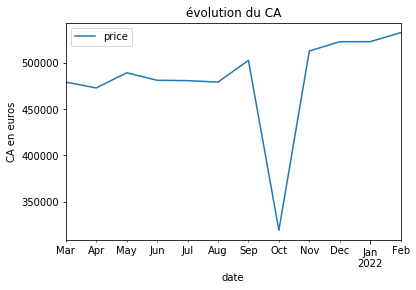

In [65]:
ca_m['price'].plot(legend=True)
plt.title('évolution du CA')
plt.ylabel('CA en euros')
plt.savefig('CA_mensuel')
plt.show()

# Baisse très importante du CA en octobre. Lien avec la rentrée scolaire de septembre ?

## Exploration de la baisse d'octobre

### Manque t-il des jours ?

In [66]:
data['2021-Oct'].resample('D')['price'].sum()

# Pas de jour manquant 

date
2021-10-01    16909.36
2021-10-02     9033.15
2021-10-03     8844.07
2021-10-04     9130.70
2021-10-05     9390.46
2021-10-06     9341.71
2021-10-07     8191.08
2021-10-08    10207.35
2021-10-09     9425.36
2021-10-10     8676.67
2021-10-11    10230.56
2021-10-12     8822.17
2021-10-13     9427.22
2021-10-14     9320.80
2021-10-15     9249.85
2021-10-16    10229.02
2021-10-17     9557.98
2021-10-18     9083.72
2021-10-19     8601.71
2021-10-20     9021.19
2021-10-21     9571.79
2021-10-22     8318.88
2021-10-23     8910.64
2021-10-24     9923.19
2021-10-25     8076.04
2021-10-26     8871.81
2021-10-27     9789.53
2021-10-28    14758.42
2021-10-29    16453.63
2021-10-30    15386.78
2021-10-31    16405.12
Freq: D, Name: price, dtype: float64

### Analyse des catégories

#### CA mensuel moyen par catégorie

In [67]:
categ_avg = data.groupby('categ')['price'].sum() / 12 # Chiffre d'affaires regroupé par catégorie et divisé par 12
categ_avg.to_numpy()

array([185810.22083342, 187282.0341667 , 109955.89249999])

In [68]:
categ_oct = data['2021-Oct'].groupby('categ')['price'].sum()
categ_oct
# CA par categ au mois d'octobre

categ
0    199217.94
1     33762.32
2     86179.70
Name: price, dtype: float64

#### Comparaison en le CA mensuel moyen par catégorie et le CA moyen par catégorie d'Octobre

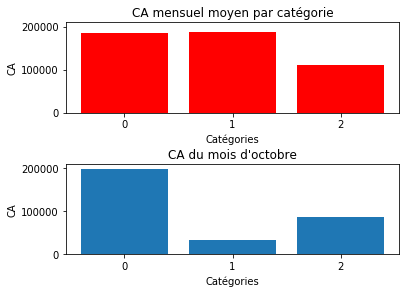

In [69]:
# Création de deux graphiques, l'un avec le CA moyen par catégorie et l'autre avec le CA par catégorie d'Octobre


plt.subplot(2,1,1)
plt.bar(list(categ_avg.index.astype(str)), list(categ_avg.values), color='red')
plt.ylim(0,210000)
plt.title('CA mensuel moyen par catégorie')
plt.xlabel('Catégories')
plt.ylabel('CA')

plt.tight_layout(2)

plt.subplot(2,1,2)
plt.bar(list(categ_oct.index.astype(str)), list(categ_oct.values))
plt.ylim(0,210000)
plt.title('''CA du mois d'octobre''')
plt.xlabel('Catégories')
plt.ylabel('CA')
plt.savefig('Ca_mensuel_CA_oct')
plt.show()

In [70]:
((data['2021-Oct'].groupby('categ')['price'].sum()) / (data.groupby('categ')['price'].sum() / 12) - 1) * 100

# le CA de la catégorie 1 à subit une baisse de 81 % par rapport à la moyenne annuelle

categ
0     7.215814
1   -81.972473
2   -21.623391
Name: price, dtype: float64

## Recherche des ventes de produits de la catégorie 1 sur octobre

In [71]:
oct_categ_1 = data['2021-oct'][data.categ == 1]

# L'alerte ne bloque pas le fonctionnement

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [72]:
# Série des ventes de la catégorie n°1 en octobre

oct_categ_1 = oct_categ_1.resample('D')['price'].sum()
oct_categ_1

date
2021-10-01    7003.79
2021-10-02       0.00
2021-10-03       0.00
2021-10-04       0.00
2021-10-05       0.00
2021-10-06       0.00
2021-10-07       0.00
2021-10-08       0.00
2021-10-09       0.00
2021-10-10       0.00
2021-10-11       0.00
2021-10-12       0.00
2021-10-13       0.00
2021-10-14       0.00
2021-10-15       0.00
2021-10-16       0.00
2021-10-17       0.00
2021-10-18       0.00
2021-10-19       0.00
2021-10-20       0.00
2021-10-21       0.00
2021-10-22       0.00
2021-10-23       0.00
2021-10-24       0.00
2021-10-25       0.00
2021-10-26       0.00
2021-10-27       0.00
2021-10-28    6317.99
2021-10-29    6425.18
2021-10-30    6753.69
2021-10-31    7261.67
Freq: D, Name: price, dtype: float64

Text(0, 0.5, "Chiffre d'affaires")

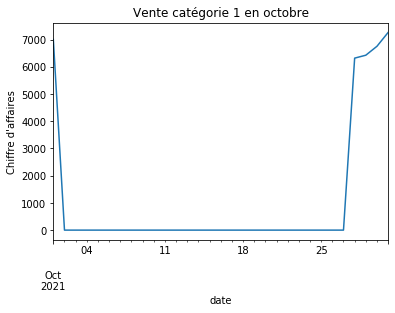

In [73]:
oct_categ_1.plot()
plt.title('Vente catégorie 1 en octobre')
plt.ylabel('''Chiffre d'affaires''')

In [74]:
# Sauvegarde du ratio = Nombre de jours de vente de la catégorie 1 / nombre de jours total

Business_days_c1 = (365 - (oct_categ_1[oct_categ_1 == 0]).count()) / 365
Business_days_c1

0.9287671232876712

Il manque les ventes de la catégorie 1 du 2 au 27 octobre inclus

# Analyse

## Principaux clients

In [75]:
client_CA = data.groupby('client_id')['price'].sum() #regroupement des CA par client
client_CA = client_CA.reset_index().sort_values('price', ascending=False ) # Classement
client_CA['percent_of_CA'] = client_CA['price'] / total_CA # %
client_CA.head(5)
# aucun client ne représente une part importante du CA
# 4 clients ont un volum d'achat supérieur à 500000€ 
# On peut supposer que ces 4 clients sont des entreprises
# il serait intéressant de leur proposer des conditions d'achat particulière

,client_id,price,percent_of_CA
677,c_1609,162007.34,0.027949
4388,c_4958,144257.21,0.024887
6337,c_6714,73197.34,0.012628
2724,c_3454,54442.92,0.009392
7715,c_7959,2564.25,0.000442


In [76]:
# Sauvegarde des 4 premiers client_id du classement dans une liste
list_customer_grossiste = list(client_CA.head(4)['client_id'])

## Catégorie

### Rappel distribution de la table products

Text(0.5, 1.1, 'Prix par catégorie')

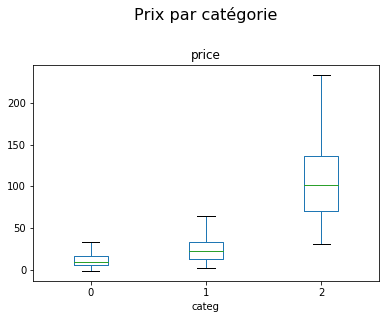

In [77]:
products.boxplot(column='price', by='categ', showfliers=False, grid=False) # boîte à moustache par catégorie
plt.suptitle('Prix par catégorie', size=16, y=1.1)

#fichier déjà enregistré

Text(0.5, 1.1, 'Prix par catégorie')

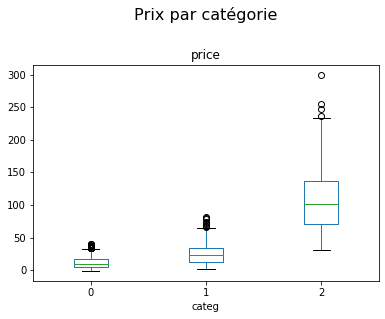

In [78]:
products.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)

#fichier déjà enregistré

### Distribution des prix par catégorie (produits vendus)

In [79]:
data.groupby('categ')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,209426.0,10.646828,4.930030,0.62,6.30,9.99,14.45,40.99
1,109735.0,20.480106,7.568956,2.00,15.81,19.08,24.98,80.99
2,17552.0,75.174949,39.079999,30.99,53.99,62.83,71.21,300.00


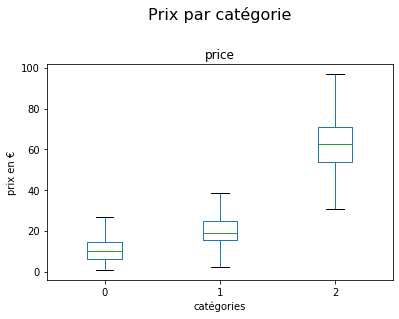

In [80]:
# Boîte à moustache des produits vendus

data.boxplot(column='price', by='categ', showfliers= False, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1);      
plt.ylabel('prix en €')
plt.xlabel('catégories')
plt.savefig('prix_categ_vendu')
plt.show()

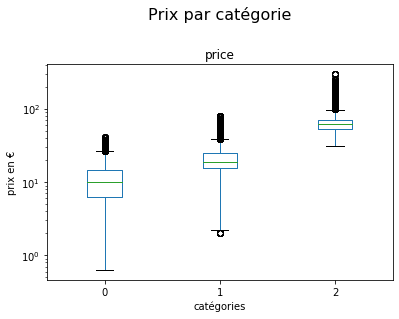

In [81]:
data.boxplot(column='price', by='categ', showfliers= True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1);  
plt.yscale('log')
plt.ylabel('prix en €')
plt.xlabel('catégories')
plt.savefig('prix_categ_vendu_outlier')
plt.show()

### Distribution des achats par client et par catégorie

In [82]:
client_categ = data.groupby(['categ','client_id'])['price'].sum() # Groupement par client et catégorie
client_categ = client_categ.to_frame()
client_categ

price
categ client_id         
0     c_1         174.20
      c_10        124.92
      c_100        31.38
      c_1000      169.85
      c_1001      527.81
...                  ...
2     c_995          NaN
      c_996          NaN
      c_997       329.11
      c_998      1331.46
      c_999          NaN

[25800 rows x 1 columns]

Text(0.5, 1.0, 'achat par catégorie')

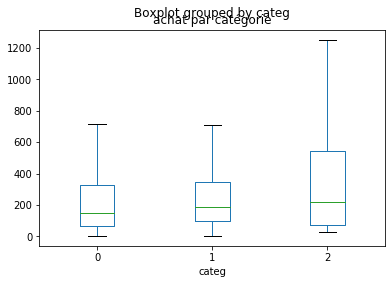

In [83]:
client_categ.boxplot(column='price', by='categ', showfliers=False, grid=False)
plt.title('achat par catégorie')

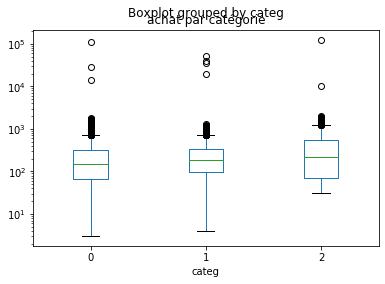

In [84]:
client_categ.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.title('achat par catégorie')
plt.yscale('log')

----

## Chiffres d'affaires

### Par produit

In [85]:
# groupement et classement
product_CA = data.groupby('id_prod')['price'].sum()
product_CA = product_CA.sort_values(ascending=False)
product_CA

id_prod
2_135     33874.09
2_112     31960.61
2_102     28919.46
2_209     27296.10
2_110     27016.50
            ...   
0_1858        1.83
0_1284        1.38
0_1840        1.28
0_1539        0.99
0_1653        0.99
Name: price, Length: 3264, dtype: float64

### Par catégorie

In [86]:
category_CA = data.groupby('categ')['price'].sum()

In [87]:
category_CA = category_CA.sort_values(ascending=False)

In [88]:
category_CA = category_CA.reset_index()

In [89]:
category_CA

,categ,price
0,1,2.247384e+06
1,0,2.229723e+06
2,2,1.319471e+06


#### Pondération de la catégorie en fonction des données manquantes

In [90]:
Business_days_c1

# = 339/365

0.9287671232876712

In [91]:

## On divise le total de la catégorie 1 par (339/365)

category_CA.loc[category_CA['categ'] == 1, 'price'] = category_CA.loc[category_CA['categ'] == 1, 'price'] / Business_days_c1

In [92]:
category_CA['percentage_of_CA'] = category_CA['price'] / total_CA

In [93]:
category_CA =category_CA.set_index('categ')

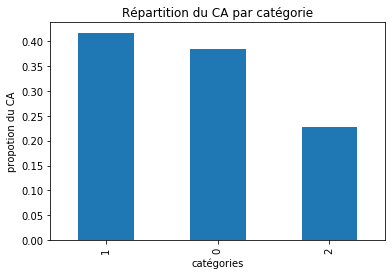

In [94]:
category_CA['percentage_of_CA'].plot(kind='bar')
plt.title('Répartition du CA par catégorie')
plt.xlabel('catégories')
plt.ylabel('propotion du CA')
plt.savefig('repartition_CA_par_categ')
plt.show()

----

## Analyse des indicateurs de tendances centrales

In [95]:
data.describe()
# prix moyen d'un livre 17.21 €
# âge moyen 45 ans des acheteurs

,birth,price
count,336713.000000,336713.000000
mean,1977.823568,17.215189
std,13.524433,17.855445
min,1929.000000,0.620000
25%,1971.000000,8.610000
50%,1980.000000,13.900000
75%,1987.000000,18.990000
max,2004.000000,300.000000


## Panier moyen

In [96]:
session_id_total = data.groupby('session_id')['price'].sum()
session_id_total 

session_id
s_1        11.99
s_10       26.99
s_100      33.72
s_1000     39.22
s_10000    41.49
           ...  
s_99994    28.92
s_99995    19.84
s_99996    56.27
s_99997     6.99
s_99998    35.11
Name: price, Length: 169173, dtype: float64

In [97]:
session_id_total.describe()

count    169173.000000
mean         34.264202
std          31.872538
min           0.620000
25%          15.200000
50%          25.560000
75%          42.980000
max         539.230000
Name: price, dtype: float64

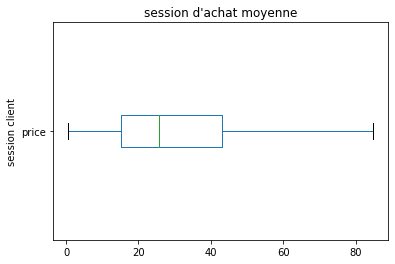

In [98]:
session_id_total.plot(kind='box', vert=False, showfliers=False)
plt.title('''session d'achat moyenne''')
plt.ylabel('session client')
plt.show()

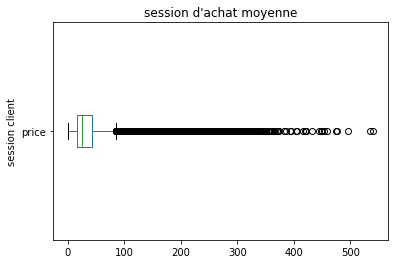

In [99]:
session_id_total.plot(kind='box', vert=False, showfliers=True)
plt.title('''session d'achat moyenne''')
plt.ylabel('session client')
plt.show()

----

### Panier moyen par client

In [100]:
panier_moyen = data.groupby(['client_id','session_id', 'birth'])['price'].sum() #groupement par client 
panier_moyen

client_id  session_id  birth
c_1        s_105105    1955      7.99
           s_114737    1955     92.62
           s_120172    1955     44.29
           s_134971    1955     10.30
           s_136532    1955     13.78
                                ...  
c_999      s_88239     1964     15.99
           s_89648     1964      5.99
           s_92374     1964      8.57
           s_98289     1964     11.99
           s_99070     1964      7.98
Name: price, Length: 169173, dtype: float64

In [101]:
panier_moyen = panier_moyen.to_frame()

In [102]:
panier_moyen = panier_moyen.reset_index()

In [103]:
panier_moyen = panier_moyen.groupby('client_id')['price'].mean() # moyenne des sessions par client

In [104]:
panier_moyen.describe()

count    8600.000000
mean       40.106253
std        22.643521
min         4.150000
25%        25.396925
50%        31.839702
75%        48.329000
max       241.160000
Name: price, dtype: float64

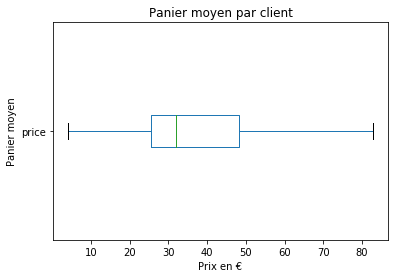

In [105]:
panier_moyen.plot(kind='box', vert=False, showfliers=False)
plt.title('Panier moyen par client')
plt.xlabel('Prix en €')
plt.ylabel('Panier moyen')
plt.savefig('panier_moyen')
plt.show()

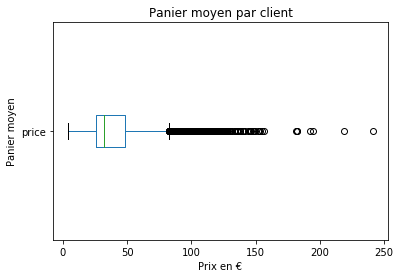

In [106]:
panier_moyen.plot(kind='box', vert=False, showfliers=True)
plt.title('Panier moyen par client')
plt.xlabel('Prix en €')
plt.ylabel('Panier moyen')
plt.savefig('panier_moyen_outliers')
plt.show()

----

# Analyses bivariées

In [107]:
# les groupes ont été défini plus bas dans le notebook mais j'ai décidé de les définir ici.
# Cela me permet de créer 'data_no_2004', 'data_no_grossiste' et 'data_no_2004_grossiste' sur cette base
data.loc[(data['birth'] < 1972), 'groupe'] = 1
data.loc[(data['birth'] > 1971)&(data['birth'] < 1992), 'groupe'] = 2
data.loc[data['birth'] > 1991, 'groupe'] = 3
data['groupe']= data['groupe'].astype('category')


data.loc[data['birth'] < 1992, 'groupe_fre'] = 1
data.loc[data['birth'] > 1991, 'groupe_fre'] = 2
data['groupe_fre']= data['groupe_fre'].astype('category')

## Préparation du dataset 

In [108]:
data_no_2004 = data[data['birth'] != 2004] # sans les clients ayant renseigné une année de naissance égale à 2004
data_no_grossiste = data[~data['client_id'].isin(list_customer_grossiste)] # sans les clients grossistes 
data_no_2004_grossiste = data[(data['birth'] != 2004)&(~data['client_id'].isin(list_customer_grossiste))] # sans les clients ayant renseigné une année de naissance égale à 2004 et sans les clients grossistes

In [109]:
sex_data_s

NameError: name 'sex_data_s' is not defined

In [ ]:
sex_data_s[['m','f']]

### Analyse par sexe

In [ ]:
sex_data = data_no_grossiste.groupby([ 'sex', 'categ', 'client_id'])['price'].sum() #groupement par par sex, catégorie et client
sex_data = sex_data.to_frame()
sex_data = sex_data.reset_index()
sex_data_s = sex_data.pivot_table(index='categ', columns='sex', values='price', aggfunc=np.sum)# pivot en effectuant une somme
sex_data_s = sex_data_s[['m','f']] # on inverse les colonnes pour les couleurs
sex_data_m = sex_data.pivot_table(index='categ', columns='sex', values='price', aggfunc=np.mean) # pivot en effectuant une moyenne
sex_data_m = sex_data_m[['m','f']] # on inverse les colonnes pour les couleurs
# Graphique
plt.figure(1)
sex_data_m.plot(kind='bar', colormap=None)
plt.title('''Chiffres d'affaires moyen par sexe et catégorie''')
plt.ylabel('Prix en €')
plt.savefig('CA_s_par_sex')
plt.figure(2)
sex_data_s.plot(kind='bar')
plt.title('''Chiffres d'affaires total par sexe et catégorie''')
plt.ylabel('Prix en €')
plt.savefig('CA_m_par_sex')
plt.show()

----

## Corrélation entre le sexe et la catégorie : Chi deux

### Méthode 1 : avec scipy

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
sex_categ = data_no_grossiste.groupby(['sex','categ'])['client_id'].count()

# le .count() va compter les doublons. On va donc comptabiliser si un client à acheter plusieurs fois des produits dans une catégorie

In [ ]:
# création du tableau de contingence
sex_categ_f = sex_categ['f'].to_numpy()
sex_categ_m = sex_categ['m'].to_numpy()
sex_categ_con = np.row_stack((sex_categ_f, sex_categ_m))
sex_categ_con

In [ ]:
# Résultats du test
chi2, pvalue, degrees, expected = chi2_contingency(sex_categ_con)
chi2, degrees, pvalue

In [ ]:
chi2_contingency(sex_categ_con)

In [ ]:
# Valeur critique pour alpha à 0.05 et degrés de liberté à 2
stats.chi2.ppf(q=1-0.05, df=2)

### Méthode 2 : avec numpy

In [ ]:
# Calcul des totaux
N = sex_categ_con.sum()
ni = sex_categ_con.sum(axis=1)
nj = sex_categ_con.sum(axis=0)
ni, nj, N

In [ ]:
# On applique la formule
nij = ni.reshape(sex_categ_con.shape[0], 1) * nj / N
nij

In [ ]:
# Calcul du chi²
d = (sex_categ_con - nij) ** 2 / nij
d.sum()

In [ ]:
# Création d'un tableau de contingence des valeurs théoriques
contingence_t = pd.DataFrame(data=nij, index=None, columns=['categ_1', 'categ_2', 'categ_3'])
contingence_t['total'] = contingence_t['categ_1'] + contingence_t['categ_2'] + contingence_t['categ_3'] 
contingence_t = contingence_t.append({'categ_1' : contingence_t['categ_1'].sum(), 'categ_2' : contingence_t['categ_2'].sum(), 'categ_3' : contingence_t['categ_3'].sum(), 'total' : contingence_t['total'].sum()}, ignore_index=True)
contingence_t['sex'] = ['homme','femme','total']
contingence_t.set_index('sex', inplace=True)
contingence_t.head()

In [ ]:
# Création d'un tableau de contingence des valeurs observées
contingence_o = pd.DataFrame(data=sex_categ_con, index=None, columns=['categ_0', 'categ_1', 'categ_2'])
contingence_o['total'] = contingence_o['categ_0'] + contingence_o['categ_1'] + contingence_o['categ_2'] 
contingence_o = contingence_o.append({'categ_0' : contingence_o['categ_0'].sum(), 'categ_1' : contingence_o['categ_1'].sum(), 'categ_2' : contingence_o['categ_2'].sum(), 'total' : contingence_o['total'].sum()}, ignore_index=True)
contingence_o['sex'] = ['homme','femme','total']
contingence_o.set_index('sex', inplace=True)
contingence_o.head()

In [ ]:
# Création d'un tableau de contingence des contributions
contingence_c = pd.DataFrame(data=d, index=None, columns=['categ_0', 'categ_1', 'categ_2'])
contingence_c['total'] = contingence_c['categ_0'] + contingence_c['categ_1'] + contingence_c['categ_2'] 
contingence_c = contingence_c.append({'categ_0' : contingence_c['categ_0'].sum(), 'categ_1' : contingence_c['categ_1'].sum(), 'categ_2' : contingence_c['categ_2'].sum(), 'total' : contingence_c['total'].sum()}, ignore_index=True)
contingence_c['sex'] = ['homme','femme','total']
contingence_c.set_index('sex', inplace=True)
contingence_c.head()

In [ ]:
# Création d'un tableau de contingence des contributions avec heatmap
sns.heatmap(contingence_c.iloc[0:2,0:3], annot=True,cmap='Reds')
plt.title('contribution au khi²')
plt.savefig('contri_chi')

### Analyse du résultat

Nous pouvons affirmer avec 0.1% de marge d'erreur que les variables ne sont pas indépendantes

Il y a une corrélation entre le sexe et la catégorie

Le plus important contibuteur est la catégorie 1 (voir d)

----

## Âge et montant des achats

In [ ]:
# Groupement par client
age_price = data_no_2004_grossiste.groupby(['birth', 'client_id', 'groupe'], observed=True)['price'].sum().to_frame()
age_price.reset_index(inplace=True)
age_price

In [ ]:
# Moyenne des montants des achats des clients par âge
age_price = age_price.groupby(['birth', 'groupe'], observed=True)['price'].mean().to_frame()
age_price.reset_index(inplace=True)

In [ ]:
# Calcul des paramètres
a,b,r,p,z = stats.linregress(age_price.birth, age_price.price)
a,b,r,p,z
# corrélation forte

In [ ]:
# calcul du coefficient de détermination
age_price_r2= r**2
age_price_r2
# coefficient de détermination proche de 1, pouvoir de prédiction fort

In [ ]:
# Représentation graphique avec seaborn
sns.regplot(age_price.birth,age_price.price)
plt.title('Âge et montant des achats')
plt.xlabel('Années de naissance')
plt.ylabel('montant des achats annuels')
plt.savefig('age_achat')

In [ ]:
# Représentation graphique classique avec matplotlib
x = np.arange(1920,2005,1)
plt.figure(1)
age_price.plot('birth', 'price', kind='scatter')
plt.title('Âge et montant des achats')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.show()

### Âge et montant des achats : identification des groupes

#### Recherche de ruptures

In [ ]:
age_price[(age_price['birth'] > 1965)&(age_price['birth'] < 1975)]
# entre 1971 et 1972

In [ ]:
age_price[(age_price['birth'] > 1985)&(age_price['birth'] < 1995)]
# entre 1991 et 1992

In [ ]:
# Definition des variables

a_pm_g1 = age_price[(age_price['birth'] < 1972)]
a_pm_g2 = age_price[(age_price['birth'] > 1971)&(age_price['birth'] < 1992)]
a_pm_g3 = age_price[age_price['birth'] > 1991]
bornes = [1920,1973,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2, a_pm_g3] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_price.describe()) # paramètres généraux

CV = age_price.describe().loc['std','price'] / age_price.describe().loc['mean','price'] # Coefficient de variation général
print('Coefficient de variation = ' +  str(CV))

# Création de la boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].price) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','price'] / a_pm_g[i].describe().loc['mean','price'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z) + '\n' + 'CV = ' + str(CV))
    age_price_r2 = r**2 # Coefficient de détermination
    print('r² = ' + str (age_price_r2) + '\n')
    print(a_pm_g[i].describe())
    sns.regplot(a_pm_g[i].birth,a_pm_g[i].price) # Graphique
    plt.title('Âge et montant des achats')
    plt.xlabel('Années de naissance')
    plt.ylabel('Prix en €')
    plt.savefig('age_achat'+ str(i))
    plt.show()
    i+=1 # incrémentation

### Boîte à moustache

In [ ]:
age_price.boxplot('price', by='groupe', grid=False)
plt.title( '''Montant des achats par catégorie d'âge''' )
plt.ylabel('Prix en €')
plt.xlabel('Groupes')
plt.savefig('boxplot_age_montante')
plt.suptitle('') 

### ANOVA

In [ ]:
#Calcul des paramètres
statf, pvalue = stats.f_oneway(age_price['price'][age_price['groupe'] == 1], age_price['price'][age_price['groupe'] == 2], age_price['price'][age_price['groupe'] == 3])
statf, pvalue

In [ ]:
# Deuxième méthode comprennant plus de détails
import statsmodels.api as sm
from statsmodels.formula.api import ols # import d'un module pour réaliser une analyse post-hoc
model = ols('price ~ C(groupe)', data=age_price).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 72
stats.f.ppf(q=1-0.05, dfn=2, dfd=72)
# Notre valeur F est largement au-dessus de la valeur critique

#### Analyse Post-hoc

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# On effectue une analyse par paires
m_comp = pairwise_tukeyhsd(endog=age_price['price'], groups=age_price['groupe'], alpha=0.05)
print(m_comp)

Toutes les paires rejettent l'hypothèse nulle

----

## Âge et fréquence des achats

In [ ]:
# On sélectionne les colonnes utiles et on supprime les doublons (en particulier les doublons dans les session_id)
age_frequence = data_no_2004_grossiste[['birth', 'client_id', 'groupe_fre', 'session_id']].drop_duplicates()
age_frequence = age_frequence.groupby([ 'birth', 'client_id', 'groupe_fre'], observed=True)['session_id'].count().to_frame().reset_index()

In [ ]:
# On effectue la moyenne du nombre de sessions par âge
age_frequence = age_frequence.groupby(['groupe_fre', 'birth'], observed=True)['session_id'].mean().to_frame().reset_index()

In [ ]:
age_frequence

In [ ]:
# Paramètres
a,b,r,p,z = stats.linregress(age_frequence.birth, age_frequence.session_id)
a,b,r,p,z
# corrélation modérée

In [ ]:
# Coefficient de détermination
age_frequence_r2= r**2
age_frequence_r2
# R² proche de 0, pouvoir de prédiction faible

In [ ]:
x = np.arange(1920,2005,1)
plt.figure(1)
age_frequence.plot('birth', 'session_id', kind='scatter')
plt.title('Âge et fréquence des achats')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.xlabel('Années de naissance')
plt.ylabel('''Nombre de sessions d'achat''')
plt.savefig('age_frequence')
plt.show()

In [ ]:
# Représentation avec un hidtogramme en 2d
plt.hist2d(age_frequence.birth, age_frequence.session_id, bins=40)
plt.title('Âge et fréquence des achats')
plt.xlabel('Année de naissance')
plt.ylabel('nombre de sessions')
plt.colorbar()

### Âge et fréquence des achats : identification des groupes

#### Recherche de ruptures

Graphiquement on identifie 2 groupes

In [ ]:
age_frequence[(age_frequence['birth'] > 1985)&(age_frequence['birth'] < 1995)]

# avant 1992 et après

#### Analyse par groupe

In [ ]:
# Definition des variables

a_pm_g1 = age_frequence[(age_frequence['birth'] < 1992)]
a_pm_g2 = age_frequence[(age_frequence['birth'] > 1991)]
bornes = [1920,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_frequence.describe())  # paramètres généraux

CV = age_frequence.describe().loc['std','session_id'] / age_frequence.describe().loc['mean','session_id']
print('Coefficient de variation = ' +  str(CV))

# boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].session_id) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','session_id'] / a_pm_g[i].describe().loc['mean','session_id'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z) +'\n'+ 'CV = ' + str(CV))
    age_frequence_r2 = r**2
    print('r² = ' + str (age_frequence_r2) + '\n')
    print(a_pm_g[i].describe())
    sns.regplot(a_pm_g[i].birth,a_pm_g[i].session_id) # Graphique
    plt.title('Âge et fréquence des achats')
    plt.xlabel('Années de naissance')
    plt.ylabel('''Nombre de sessions d'achat''')
    plt.savefig('age_fre'+ str(i))
    plt.show()
    i+=1 # incrémentation

### Boîte à moustache

In [ ]:
age_frequence.boxplot('session_id', by='groupe_fre', grid=False)
plt.title( '''Fréquence des achats par catégorie d'âge''' )
plt.ylabel('Nombre de sessions')
plt.xlabel('Groupes')
plt.suptitle('') 

### ANOVA

In [ ]:
# Calcul des paramètres
model = ols('session_id ~ C(groupe_fre)', data=age_frequence).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
# Calcul de la valeur critique pour des degrés de liberté de 1 et 73
stats.f.ppf(q=1-0.05, dfn=1, dfd=73)

# Notre valeur F est largement au-dessus de la valeur critique

----

# Âge et le panier moyen

In [ ]:
# On compte le nombre d'articles par client et session
age_panier_moyen = data_no_2004_grossiste.groupby(['birth','session_id','client_id','groupe'], observed=True)['id_prod'].count().to_frame().reset_index()
age_panier_moyen

In [ ]:
# Panier moyen par client
age_panier_moyen = age_panier_moyen.groupby(['client_id', 'birth', 'groupe'], observed=True)['id_prod'].mean().to_frame().reset_index()
age_panier_moyen

In [ ]:
# moyenne des paniers moyens par âge
age_panier_moyen = age_panier_moyen.groupby(['birth', 'groupe'], observed=True)['id_prod'].mean().to_frame().reset_index()
age_panier_moyen

In [ ]:
age_panier_moyen.describe()

In [ ]:
# Calcul des paramètres
a,b,r,p,z = stats.linregress(age_panier_moyen.birth, age_panier_moyen.id_prod)
a,b,r,p,z 
# la corrélation est modérée

In [ ]:
# Calcul du coefficient de variation
age_panier_moyen_r2 = r**2
age_panier_moyen_r2
# pouvoir de prédiction faible

In [ ]:
x = np.arange(1920,2005,1)
plt.figure(1)
age_panier_moyen.plot('birth', 'id_prod', kind='scatter')
plt.title('Âge et panier moyen')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.xlabel('Années de naissance')
plt.ylabel('''Nombre d'articles moyen''')
plt.savefig('age_panier_moyen')
plt.show()

In [ ]:
# Représentaiton graphique avec des hexagones de densité
plt.hexbin(age_panier_moyen.birth, age_panier_moyen.id_prod)
plt.title('Âge et panier moyen')
plt.xlabel('Année de naissance')
plt.ylabel('Prix en  €')
plt.colorbar()

### Âge et panier moyen : identification des groupes

Sur ces graphiques on peut indentifier 3 groupes distincts

#### Recherche de ruptures

In [ ]:
age_panier_moyen[(age_panier_moyen['birth'] > 1965)&(age_panier_moyen['birth'] < 1975)]
# Ecart significatif entre 1971 et 1972

In [ ]:
age_panier_moyen[(age_panier_moyen['birth'] > 1985)&(age_panier_moyen['birth'] < 1995)]
# Ecart significatif entre 1991 et 1992

#### Analyse par groupe

Définition de 3 groupes :
- a_pm_g1 : Clients nés avant 1972 (50 ans en 2022)
- a_pm_g2 : Clients nés entre 1972 et 1992 (entre 50 et 30 ans en 2022)
- a_pm_g3 : Clients nés après 1992 (30 ans et en-dessous)

In [ ]:
# Definition des variables
a_pm_g1 = age_panier_moyen[age_panier_moyen['birth'] < 1972]
a_pm_g2 = age_panier_moyen[(age_panier_moyen['birth'] > 1971)&(age_panier_moyen['birth'] < 1992)]
a_pm_g3 = age_panier_moyen[age_panier_moyen['birth'] > 1991]
bornes = [1920,1973,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2, a_pm_g3] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_panier_moyen.describe()) # paramètres généraux

CV = age_panier_moyen.describe().loc['std','id_prod'] / age_panier_moyen.describe().loc['mean','id_prod'] # Coefficient de variation général
print('Coefficient de variation = ' +  str(CV) +'\n')

# Création de la boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].id_prod) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','id_prod'] / a_pm_g[i].describe().loc['mean','id_prod'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z)+'\n' + 'CV = ' + str(CV) +'\n')
    age_panier_moyen_r2 = r**2 # Coefficient de détermination
    print(a_pm_g[i].describe())
    print('r² = ' + str (age_panier_moyen_r2) + '\n')
    x = np.arange(bornes[i],bornes[i+1],1)
    plt.figure(1)
    a_pm_g[i].plot('birth', 'id_prod', kind='scatter') # Graphique
    plt.title('Âge et panier moyen')
    plt.figure(2)
    plt.plot(x, a*x+b, 'red')
    plt.xlabel('Années de naissance')
    plt.ylabel('''Nombre d'articles''')
    plt.savefig('age_panier'+ str(i))
    plt.show()
    i+=1 # incrémentation

les valeurs p des 3 groupes sont faibles. En effet, la clientèle a été divisé en 3 groupes homogènes.

In [ ]:
age_panier_moyen.describe()

l'écart type a grandement diminué. il état de 0.417 dans la population totale est il passe à :
- groupe 1 : 0.071
- groupe 2 : 0.026
- groupe 3 : 0.047


### boîte à moustache par groupe

In [ ]:
age_panier_moyen.boxplot('id_prod', by='groupe', grid=False)
plt.title( '''Panier par catégorie d'âge''' )
plt.ylabel('''Nombre d'articles''')
plt.xlabel('Groupes')
plt.suptitle('') 

### ANOVA

In [ ]:
# Méthode 1
statf, pvalue = stats.f_oneway(age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 1], age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 2], age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 3])
statf, pvalue

In [ ]:
# Méthode 2
model = ols('id_prod ~ C(groupe)', data=age_panier_moyen).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 72
stats.f.ppf(q=1-0.05, dfn=2, dfd=72)

# Notre valeur F est largement au-dessus de la valeur critique

#### Analyse Post-hoc

In [ ]:
m_comp = pairwise_tukeyhsd(endog=age_panier_moyen['id_prod'], groups=age_panier_moyen['groupe'], alpha=0.05)
print(m_comp)

Toutes les paires rejettent l'hypothèse nulle

----

## Âge et catégorie

In [ ]:
data_no_2004_grossiste.groupby('categ')['birth'].describe()

### ANOVA

In [ ]:
model = ols('birth ~ C(categ)', data=data_no_2004_grossiste).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 306201
stats.f.ppf(q=1-0.05, dfn=2, dfd=306201)

# Notre valeur F est largement au-dessus de la valeur critique

#### Post-hoc

In [ ]:
m_comp = pairwise_tukeyhsd(endog=data_no_2004_grossiste['birth'], groups=data_no_2004_grossiste['categ'], alpha=0.05)
print(m_comp)

#### Conclusions

H0 = "la moyenne des groupes sont égales" 

H1 = "Au moins, l'une des moyennes d'un groupe est différente des autres groupes"

Toutes les paires de groupe rejettent l'hypothèse H0. En d'autres termes : en fonction de la catégorie, la moyenne d'âge des acheteurs est différente.

### Visualisation de la distribution des données en fonctions des groupes

In [ ]:
sns.violinplot(x='categ', y='birth', data=data_no_2004_grossiste)
plt.title('Âge et la catégorie')
plt.xlabel('Catégories')
plt.ylabel('Années de naissance')
plt.savefig('age_categ')
plt.show()

Catégorie 0 = concentration des données au sein de la tranche d'âge 1970 - 1990 (groupe de clients entre 30 et 50 ans)

Catégorie 1 = Les enregistrements s'étalent assez uniformément entre les différentes tranches d'âge

Catégorie 2 = Concentration des données au sein de la tranche d'âge inférieur à 1990 (les - de 30)

----

## Poids des groupes dans le chiffre d'affaires

In [ ]:
total_ca_g1 = data_no_2004_grossiste[data_no_2004_grossiste['birth'] < 1972]['price'].sum()
total_ca_g2 = data_no_2004_grossiste[(data_no_2004_grossiste['birth'] > 1971)&(data_no_2004_grossiste['birth'] < 1992)]['price'].sum()
total_ca_g3 = data_no_2004_grossiste[data_no_2004_grossiste['birth'] > 1991]['price'].sum()
total_ca = data_no_2004_grossiste['price'].sum()

per_ca_g1 = total_ca_g1 / total_ca
per_ca_g2 = total_ca_g2 / total_ca
per_ca_g3 = total_ca_g3 / total_ca

per_ca_g1, per_ca_g2, per_ca_g3


In [ ]:
per_ca_g1+ per_ca_g2+ per_ca_g3

---

## Courbe de Lorenz et coefficient de Gini

In [ ]:
# CA par client
X = data.groupby('client_id')['price'].sum()
X = X.to_numpy()
X = np.sort(X) # tri des valeurs

In [ ]:
def lorenz(X):
    # On divis la somme cumulé par la somme 
    # afin avoir un résultat entre 0 et 1
    scaled_prefix_sum = X.cumsum() / X.sum()
    # On met en place la première valeur à 0
    return np.insert(scaled_prefix_sum, 0, 0)

lorenz_curve = lorenz(X)

plt.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
# on affiche une ligne de 0,0 à 1,1
plt.plot([0,1], [0,1])
plt.xlabel('''% de client''')
plt.grid()
plt.ylabel('''% du chiffre d'affaires''')
plt.title('courbe de Lorenz')
plt.annotate('les 4 clients grossistes', xy=(1,0.92), xytext=(0.45,0.95),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('50% des clients produisent 20% du CA', xy=(0.5,0.2), xytext=(0.45,0.35),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.savefig('Lorenz')
plt.show()

In [ ]:
# Calcul du coefficient de gini

n = X.size # Taille de l'échantillon
i = np.arange(1, n + 1) # Index commençant à 1


# Application de la formule
(np.sum((2 * i - n  - 1) * X)) / (n * np.sum(X))